# Apect-based Sentiment Analysis

Analyzing customer reviews based on specific aspects enhances our comprehension of the aspects that customers appreciate and those they find unfavorable about the product.Analyzing customer reviews based on specific aspects enhances our comprehension of the aspects that customers appreciate and those they find unfavorable about the product.

This experiment showcases the utilization of Language Models (LLMs) such as ChatGPT by OpenAI for the analysis of customer reviews. Initially, we instruct the LLM to identify various aspects within a customer review, generating a record for each aspect along with its corresponding sentiment and justification.

Given the LLM's ability to autonomously define new aspects, reviews for a specific product may yield differently phrased aspects. To identify common topics, we employ an LLM for vector embedding of each aspect, forming clusters. Subsequently, we task the LLM with generating a title that encapsulates the terms within each cluster.This experiment showcases the utilization of Language Models (LLMs) such as ChatGPT by OpenAI for the analysis of customer reviews. Initially, we instruct the LLM to identify various aspects within a customer review, generating a record for each aspect along with its corresponding sentiment and justification.

Given the LLM's ability to autonomously define new aspects, reviews for a specific product may yield differently phrased aspects. To identify common topics, we employ an LLM for vector embedding of each aspect, forming clusters. Subsequently, we task the LLM with generating a title that encapsulates the terms within each cluster.

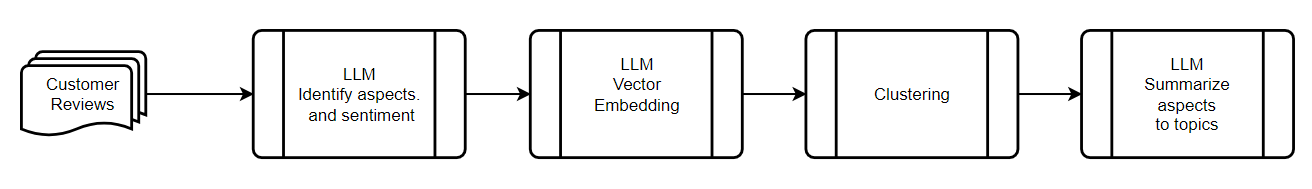


https://medium.com/data-science-at-microsoft/from-reviews-to-insights-building-analytic-applications-with-large-language-models-in-e-commerce-ad28ee60e2a7
 
**Additional references:**
- https://www.amazon.science/publications/instruction-tuning-for-few-shot-aspect-based-sentiment-analysis
- https://intellica-ai.medium.com/aspect-based-sentiment-analysis-everything-you-wanted-to-know-1be41572e238

## Setup 

In [1]:
%reload_ext autoreload
%autoreload 2

import os
jp = os.path.join
import sys
import json
import pandas as pd
import glob
import datetime
T_now = datetime.datetime.now
import logging

#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.basicConfig(level=logging.DEBUG)

SRC_DIRS = ['../src']
for sd in reversed(SRC_DIRS):
    if sd not in sys.path:
        sys.path.insert(0, sd)

from reviewanalysis import (
    GPT,
    Embedding,
    print_shape,
    filter_by_styles,
    create_product_dict,

from reviewanalysis.gpt_class import DEFAULT_PROMPT, CATEGORY_PROMPT

# Prepare for ChatGPT
gptchat = GPT()

/opt/anaconda3/envs/conda-python3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


ImportError: cannot import name 'HOME_DIR' from 'reviewanalysis' (/home/pmolnar/Projects/GenAI-Workshop/genai-exercises/TextAnalysis/reviewanalysis/__init__.py)

## Load Customer Reviews

Loading customer review data.

In [6]:
reviews_df = load_customer_reviews()
sel_reviews_df = filter_by_styles(reviews_df)

We focus on these selected styles:

In [7]:
sel_products = create_product_dict(sel_reviews_df)
display(sel_products)

{'13108': {'Product Title': 'Ingenuity Full Course 6-in-1 High Chair – Astro',
  'Manufacturer': 'Kids II',
  'Brand': 'Ingenuity',
  'Account Category': 'Home *** Highchairs'},
 '12889': {'Product Title': 'Baby Einstein Playful Painter Magic Touch Color Palette',
  'Manufacturer': 'Kids II',
  'Brand': 'Baby Einstein',
  'Account Category': 'Toy *** Infant/Toddler Toy'},
 '16650': {'Product Title': 'Bright Starts Bright Starts Ways to Play Walker - Ford Bronco, Area 51, 4-in-1 Walker',
  'Manufacturer': 'Kids II',
  'Brand': 'Bright Starts',
  'Account Category': 'Home *** Walkers'},
 '12395': {'Product Title': "Baby Einstein Earl's Sound Explorer Day-to-Night Bluetooth Soother",
  'Manufacturer': 'Kids II',
  'Brand': 'Baby Einstein',
  'Account Category': 'Toy *** Box Toy'},
 '12563': {'Product Title': 'Ingenuity Dream Hero 3-in-1 Co-Sleeping Bassinet - Constellation',
  'Manufacturer': 'Kids II',
  'Brand': 'Ingenuity',
  'Account Category': 'Uncategorized'}}

## Baby Einstein Earl's Sound Explorer Day-to-Night Bluetooth Soother

Style: 12395

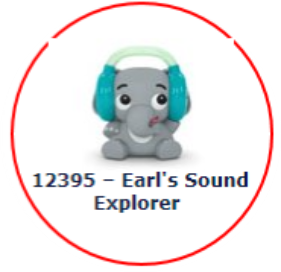

In [13]:
style = '12395'
display(sel_products[style])

# filter reviews for selected product
single_product_df = filter_by_styles(reviews_df, sel_styles=[style], unique=True)

not_null_reviews = pd.notnull(single_product_df['Review Text']).sum()
print(f"Number of reviews: {not_null_reviews:,}")

{'Product Title': "Baby Einstein Earl's Sound Explorer Day-to-Night Bluetooth Soother",
 'Manufacturer': 'Kids II',
 'Brand': 'Baby Einstein',
 'Account Category': 'Toy *** Box Toy'}

Number of reviews: 153


### Step 1: Aspect-based Sentiment Analysis

Use the following prompt on each of the reviews:

In [11]:
print(DEFAULT_PROMPT)

Analyze the provided review delimited by <> and extract product-related
aspects, sentiments (positive/negative/neutral), and justifications.
Format the result as JSON object with the following structure: a key named 'aspect'
containing a nested object with keys for each aspect, and each aspect having an object with
'sentiment' and 'justification' keys.
Exclude non-product discussions. If no sentiment is expressed for an aspect, return
'neutral' as the sentiment and 'No information provided' as the value. If information
can't be retrieved, return an empty JSON object.
Review: <{review}>



In [85]:
sentiment_df = gptchat.analyze_reviews_from_table(single_product_df, prompt_label='default', to_lower=True)
display(sentiment_df.head())

Processing...: 153it [00:00, 406.44it/s]


,aspect,sentiment,justification,elapsed_seconds,hash,prompt_label,Product Model Number,ID,Duplicate Group,Star Rating
0,baby boy,positive,He loves it he will watch almost every night b...,None,None,None,12395,87502,54336,4
1,plug,negative,One down side there is no way to plug it in it...,None,None,None,12395,87502,54336,4
2,batteries,negative,So it is really annoying to have to buy new ba...,None,None,None,12395,87502,54336,4
0,product,negative,Came damaged and had to be returned.,None,None,None,12395,87700,54451,1
1,chance to use,negative,Very disappointed that we never got the chance...,None,None,None,12395,87700,54451,1


#### List of Positive Aspects

In [134]:
positive_aspects = sorted(sentiment_df[sentiment_df.sentiment=='positive'].aspect.drop_duplicates().values)
print(f"Number of terms: {len(positive_aspects):,}")
print(', '.join(positive_aspects))

Number of terms: 220
additional noises, adjustment, amazing battery life, animation, appearance, assembly, attention, automatic shut off, automatic shut-off, baby, baby boy, baby einstein products, baby einstein sea dreams soother, baby likes looking at it, baby sleep, baby tv, baby's attention, baby's preference, bassinet, batteries last longer, battery, battery life, beautiful, bedtime routine, better for older babies in the crib, birthday gift, bluetooth, bluetooth connectivity, bluetooth speaker, box, brand, build quality, built, button, button design, buying decision, calming, calming effect, calming tool, capturing attention, car ride, car seat toy, charge, charger, charging method, christmas present, classical music, cleaning, colors, connecting the bluetooth, construction, contentment, crib, crib toy, cute, cute and soothing, daughter, demeanor, design, device, different sounds, disabilities, discovery settings, distraction, durability, earl the elephant, ease of opening packag

#### List of Negative Aspects

In [135]:
negative_aspects = sorted(sentiment_df[sentiment_df.sentiment=='negative'].aspect.drop_duplicates().values)
print(f"Number of terms: {len(negative_aspects):,}")
print(', '.join(negative_aspects))

Number of terms: 93
baby, baby sleep, batteries, battery, battery life, battery's durability, blue lights, bluetooth audio, brand, breaking, bright, brightness, button, buttons, c batteries, c batteries (duracell), car seat, chance to use, charge, clicking sound, compatibility, controller, cost, crib rail, disappointed, durability, expensive, fall asleep, functionality, hang on crib, heavy, helps babies sleep, hype, installation, ipad, items, kick piano, light, lights shut off, loud, loudness, lullabies, manual, mechanical, mechanics, money, movement, music, mute, noise, noise level, plug, plug in, price, product, product accessories, product condition, product quality, producto, purchase, quietness, rechargeable, reliability, remote, remote control, replacement machine, safety of item, size, sound, sound options, sound quality, speaker, star, stay asleep, strap, straps, support, timer, toy, trim, trouble shooting, turn on, turning on, useful, value for money, volume, volume control, v

### Step 2: Vector Embedding and Clustering

In [136]:
embedding_df = gptchat.embedding_from_table(sentiment_df, vect_col='embedding')
print(f"Number of records: {embedding_df.shape[0]:,}")

display(embedding_df.head(3).T)

Number of records: 514


,0,1,2
aspect,baby boy,plug,batteries
sentiment,positive,negative,negative
justification,He loves it he will watch almost every night b...,One down side there is no way to plug it in it...,So it is really annoying to have to buy new ba...
elapsed_seconds,None,None,None
hash,None,None,None
prompt_label,None,None,None
Product Model Number,12395,12395,12395
ID,87502,87502,87502
Duplicate Group,54336,54336,54336
Star Rating,4,4,4


#### Calculate Affinity Matrix

In [139]:
aspects_df = embedding_df.groupby('aspect').agg({'embedding': 'first'}) \
    .reset_index()

In [97]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import SpectralClustering

import matplotlib.pyplot as plt

In [140]:
# X = np.stack(embedding_df[embedding_df.sentiment=='negative']['text-embedding-ada-002'].values)
X = np.stack(aspects_df['embedding'].values)
# z_sentiment = embedding_df.sentiment.map(lambda x: {'negative': -1, 'neutral': 0, 'positive': 1}[x]).values
print(X.shape)

(306, 1536)


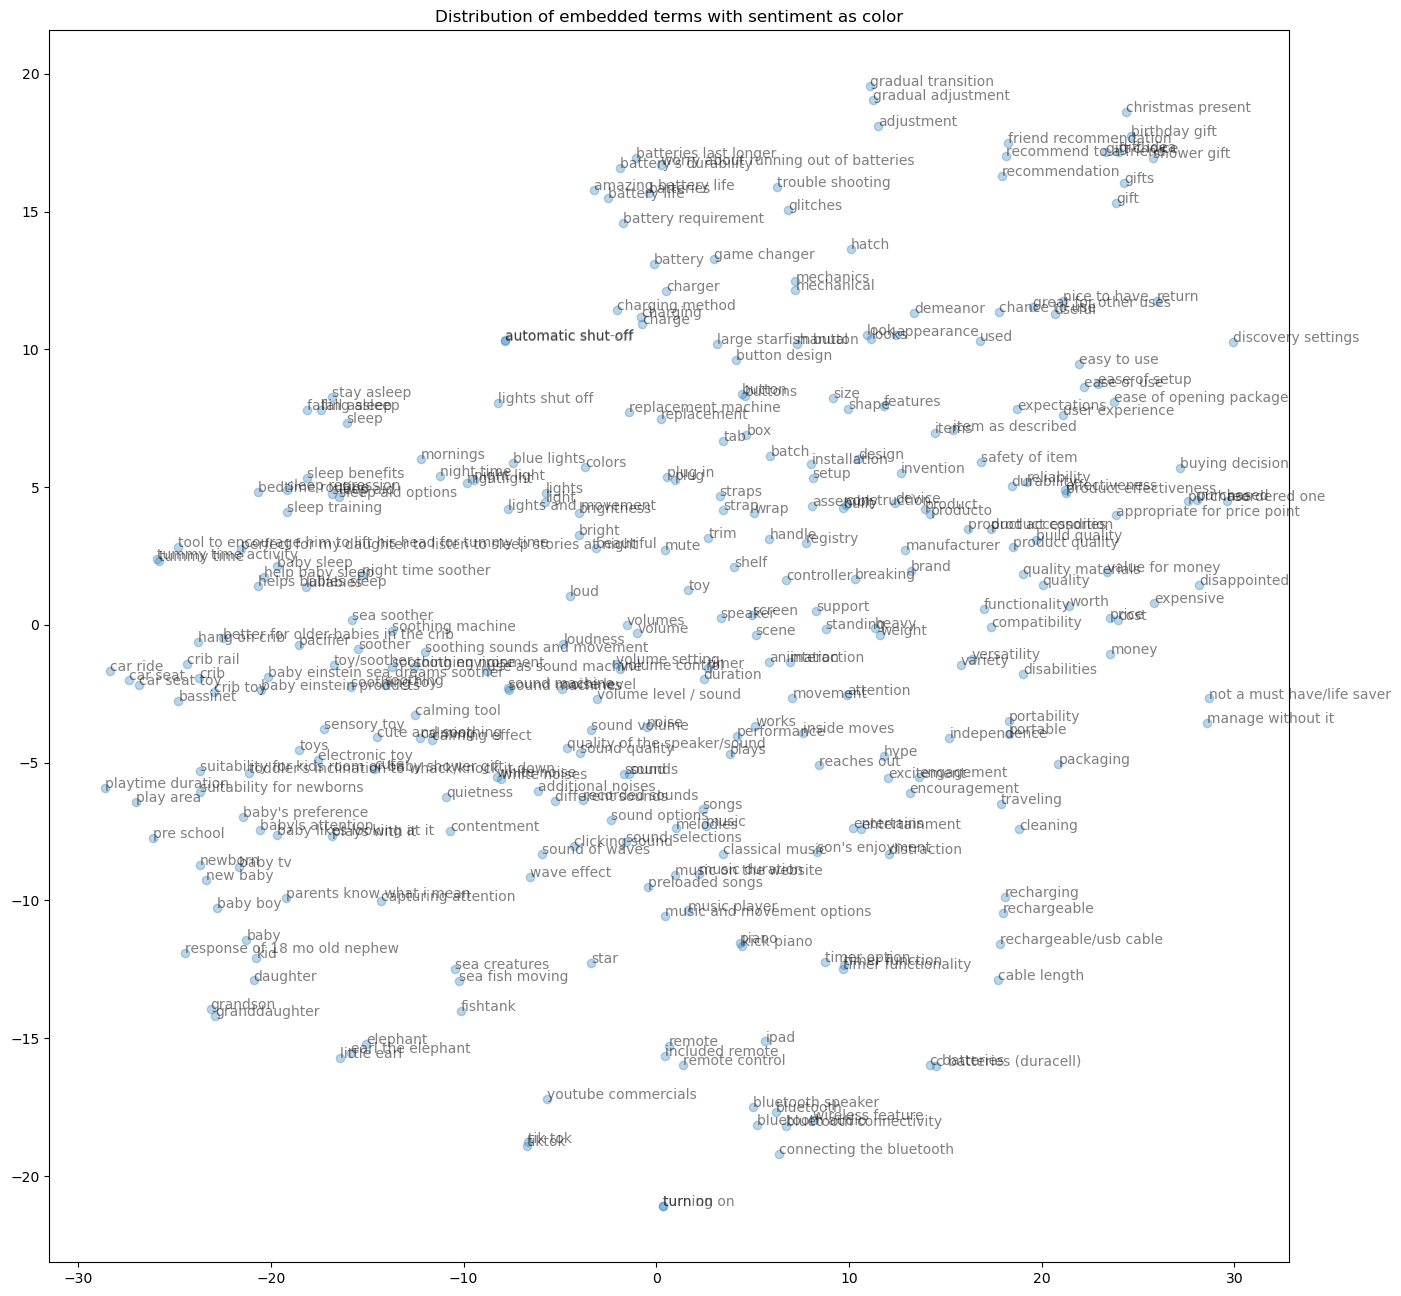

In [142]:
# Create a t-SNE object
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200)

# Fit and transform your data
X_tsne = tsne.fit_transform(X)

t_aspects = aspects_df.aspect.map(str)
plt.figure(figsize=(16, 16))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3)
plt.title("Distribution of embedded terms with sentiment as color")
for i in range(X.shape[0]):
    plt.text(X_tsne[i,0], X_tsne[i, 1], t_aspects[i], fontsize=10, alpha=0.5)
plt.show()

(306, 306)


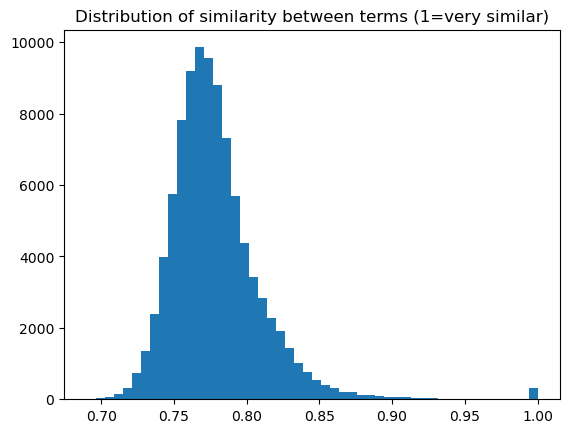

In [148]:
affinity_matrix = cosine_similarity(X)
# affinity_matrix = euclidean_distances(X_tsne)

print(affinity_matrix.shape)

plt.hist(affinity_matrix.reshape(-1), bins=50)
plt.title("Distribution of similarity between terms (1=very similar)")
plt.show()

#### Clustering

(306,)


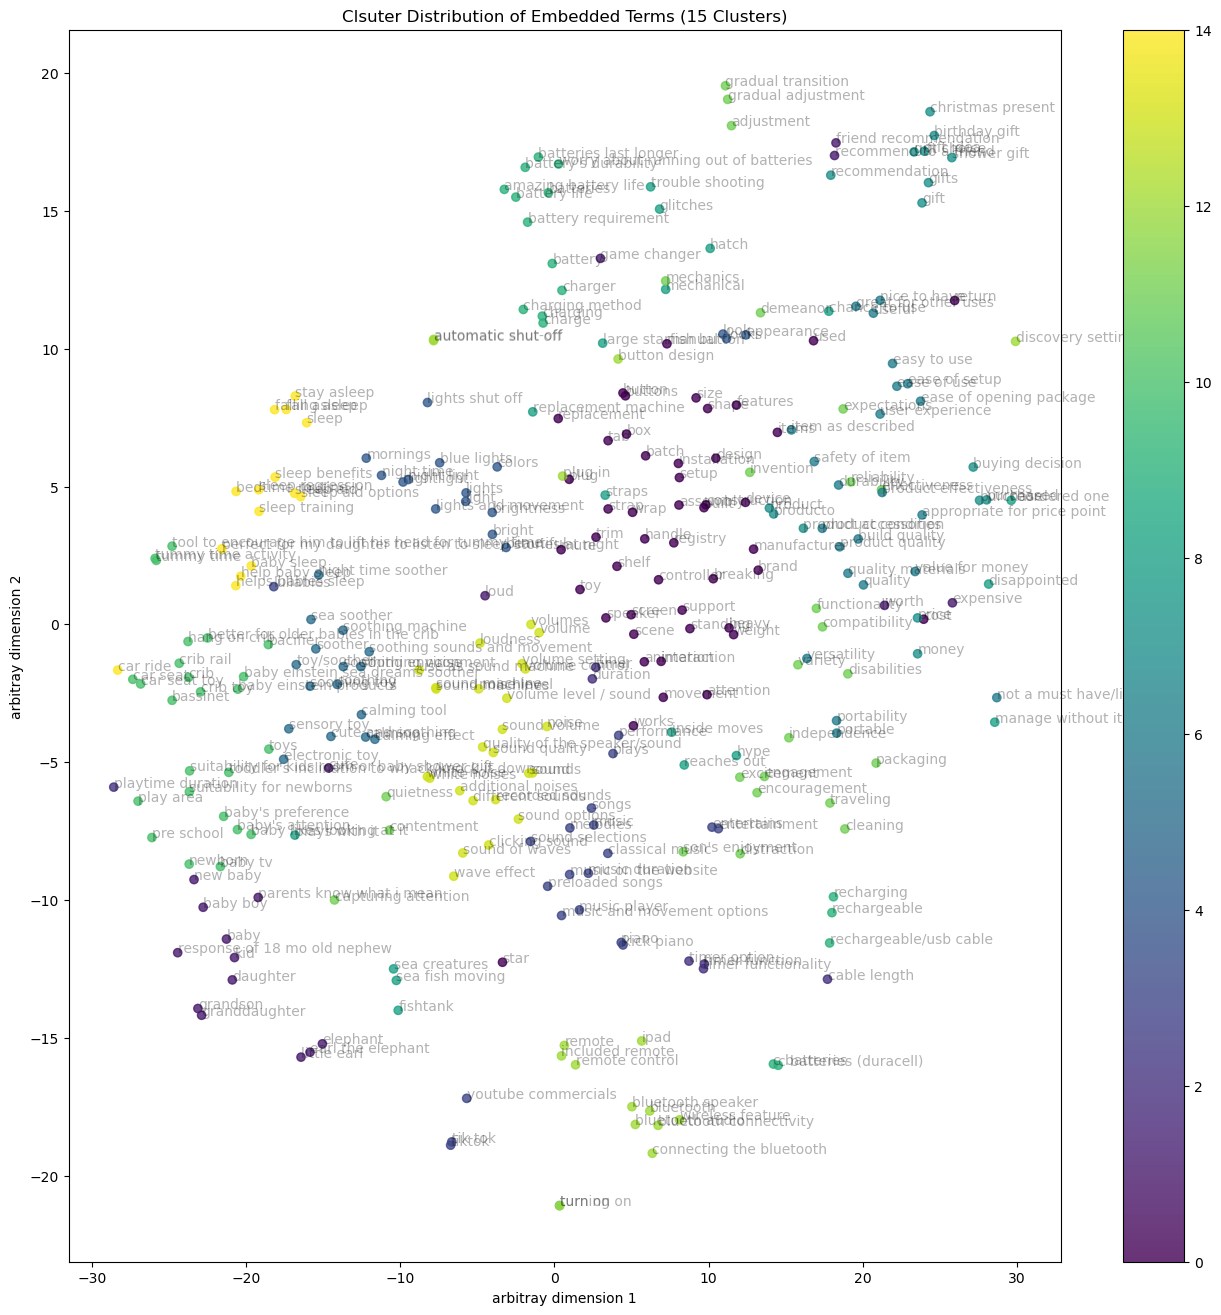

In [153]:
# Define Number of Clusters
number_of_clusters = 15

sc = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')

cluster_labels = sc.fit_predict(affinity_matrix)
print(cluster_labels.shape)

cluster_df = pd.DataFrame({'aspect': aspects_df['aspect'], 'cluster': cluster_labels})
# display(cluster_df.head())

jdf = pd.merge(aspects_df, cluster_df.drop_duplicates(), on='aspect', how='inner')
assert jdf.shape[0] == aspects_df.shape[0], "Mismatch after join"

z_cluster = jdf.cluster.values
plt.figure(figsize=(16,16))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=z_cluster, alpha=0.8)
plt.colorbar()
plt.title(f"Clsuter Distribution of Embedded Terms ({number_of_clusters} Clusters)")
plt.xlabel("arbitray dimension 1")
plt.ylabel("arbitray dimension 2")

for i in range(X.shape[0]):
    plt.text(X_tsne[i,0], X_tsne[i, 1], t_aspects[i], fontsize=10, alpha=0.3)
plt.show()

### Step 3: Generate Category Titles

In [155]:
cluster_categories = {}

for cluster in range(number_of_clusters):
    
    key_terms = cluster_df[cluster_df.cluster==cluster].aspect.drop_duplicates().values
    
    category_res = gptchat.category_for_key_terms(key_terms)
    category = category_res.get('category', 'UNKNOWN').upper()
    cluster_categories[cluster] = category
    print(f"Cluster {cluster}: {category}\n")
    print(', '.join(key_terms))
    print('')
          

Cluster 0: KEY TERMS

animation, assembly, attention, batch, box, brand, breaking, built, button, buttons, construction, controller, cost, design, device, features, handle, heavy, installation, interaction, items, manual, manufacturer, movement, mute, plug, registry, replacement, return, scene, screen, setup, shape, shelf, size, speaker, standing, star, strap, support, tab, toy, trim, used, weight, works, wrap

Cluster 1: KEY TERMS

baby, baby boy, cute, daughter, earl the elephant, elephant, expensive, friend recommendation, game changer, granddaughter, grandson, kid, little earl, loud, new baby, parents know what i mean, recommend to a friend, response of 18 mo old nephew, worth

Cluster 2: TIMER

cable length, duration, playtime duration, timer, timer function, timer functionality, timer option

Cluster 3: MUSIC

classical music, entertainment, entertains, kick piano, lullabies, melodies, music, music and movement options, music duration, music on the website, music player, performa

In [156]:
cluster_df['aspect_category'] = cluster_df.cluster.map(lambda c: cluster_categories[c])

### Analysis

The clustering makes sense for some aspects, but not so much for others. Even the LLM figured that out and assigned the label "KEY TERMS" to those clusters for which it couldn't find a meaningful title. Those clusters are not shown in the summary

In [172]:
jdf = pd.merge(embedding_df, cluster_df, on='aspect', how='left')
print(jdf.shape)

table_sentiment = pd.pivot_table(jdf, index=['cluster', 'aspect_category'], columns=['sentiment'], values='ID', aggfunc='count', fill_value=0) \
    .reset_index() \
    .sort_values('aspect_category')

table_rating = pd.pivot_table(jdf, index=['cluster', 'aspect_category'], columns=['sentiment'], values='Star Rating', aggfunc='mean', fill_value=0) \
    .reset_index() \
    .sort_values('aspect_category')

summary_df = pd.merge(table_sentiment, table_rating, on=['cluster', 'aspect_category'], suffixes=['_count', '_rating'])
display(summary_df[summary_df.aspect_category!='KEY TERMS'])

(514, 13)


sentiment,cluster,aspect_category,negative_count,neutral_count,positive_count,negative_rating,neutral_rating,positive_rating
0,9,BATTERY,17,5,11,3.000000,3.800000,4.545455
1,7,GIFTS,16,0,28,2.000000,0.000000,4.750000
8,4,LIGHTING,7,1,27,2.857143,5.000000,4.518519
9,3,MUSIC,5,3,31,3.000000,3.000000,4.838710
10,14,SLEEP,5,3,17,3.800000,4.666667,4.352941
11,5,SOOTHING TOY,0,1,20,0.000000,1.000000,4.800000
12,13,SOUND,17,4,24,2.882353,4.750000,4.958333
13,12,TECHNOLOGY,8,4,22,2.750000,4.500000,4.681818
14,2,TIMER,1,2,4,4.000000,4.500000,4.750000


The table above shows positive sentiment towards "lighting", "sleep", "soothing toy", "sound" and "technology". Customers seem to be satisfied with the product and its purpose. However, they express dissatisfaction related to the batteries.

## Ingenuity Full Course 6-in-1 High Chair

Style: 13108

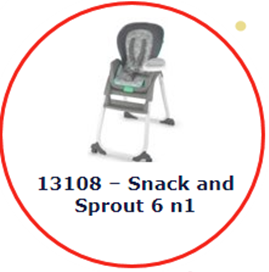

In [171]:
style = '13108'
display(sel_products[style])

# filter reviews for selected product
single_product_df = filter_by_styles(reviews_df, sel_styles=[style], unique=True)

not_null_reviews = pd.notnull(single_product_df['Review Text']).sum()
print(f"Number of reviews: {not_null_reviews:,}")

{'Product Title': 'Ingenuity Full Course 6-in-1 High Chair – Astro',
 'Manufacturer': 'Kids II',
 'Brand': 'Ingenuity',
 'Account Category': 'Home *** Highchairs'}

Number of reviews: 400


### Analysis

In [174]:
sentiment_df = gptchat.analyze_reviews_from_table(single_product_df, prompt_label='default', to_lower=True)
display(sentiment_df.head())

Processing...: 400it [00:01, 359.23it/s]


,aspect,sentiment,justification,elapsed_seconds,hash,prompt_label,Product Model Number,ID,Duplicate Group,Star Rating
0,chair,negative,I hate cleaning this chair,9.478852,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,default,13108,19198,12878,2
1,fisher price spacesaver,positive,I will be going back to the Fisher Price space...,9.478852,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,default,13108,19198,12878,2
2,defective,negative,Maybe my chair is defective,9.478852,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,default,13108,19198,12878,2
3,messy eater,negative,Great chair if you don't have a messy eater,9.478852,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,default,13108,19198,12878,2
4,cleaning,negative,I hate cleaning this chair,9.478852,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,default,13108,19198,12878,2


In [175]:
embedding_df = gptchat.embedding_from_table(sentiment_df, vect_col='embedding')
print(f"Number of records: {embedding_df.shape[0]:,}")

display(embedding_df.head(3).T)

Number of records: 1,297


,0,1,2
aspect,chair,fisher price spacesaver,defective
sentiment,negative,positive,negative
justification,I hate cleaning this chair,I will be going back to the Fisher Price space...,Maybe my chair is defective
elapsed_seconds,9.478852,9.478852,9.478852
hash,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...,21eb0b9a47b6ad3a2a08e5f511763f95ce43ae4cba61b8...
prompt_label,default,default,default
Product Model Number,13108,13108,13108
ID,19198,19198,19198
Duplicate Group,12878,12878,12878
Star Rating,2,2,2


In [176]:
aspects_df = embedding_df.groupby('aspect').agg({'embedding': 'first'}) \
    .reset_index()

In [177]:
X = np.stack(aspects_df['embedding'].values)
print(X.shape)

(445, 1536)


In [178]:
affinity_matrix = cosine_similarity(X)
# affinity_matrix = euclidean_distances(X_tsne)

print(affinity_matrix.shape)


(445, 445)


In [179]:
# Define Number of Clusters
number_of_clusters = 15

sc = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')

cluster_labels = sc.fit_predict(affinity_matrix)
print(cluster_labels.shape)

cluster_df = pd.DataFrame({'aspect': aspects_df['aspect'], 'cluster': cluster_labels})
# display(cluster_df.head())

jdf = pd.merge(aspects_df, cluster_df.drop_duplicates(), on='aspect', how='inner')
assert jdf.shape[0] == aspects_df.shape[0], "Mismatch after join"


(445,)


In [180]:
cluster_categories = {}

for cluster in range(number_of_clusters):
    
    key_terms = cluster_df[cluster_df.cluster==cluster].aspect.drop_duplicates().values
    
    category_res = gptchat.category_for_key_terms(key_terms)
    category = category_res.get('category', 'UNKNOWN').upper()
    cluster_categories[cluster] = category
    print(f"Cluster {cluster}: {category}\n")
    print(', '.join(key_terms))
    print('')
cluster_df['aspect_category'] = cluster_df.cluster.map(lambda c: cluster_categories[c])

Cluster 0: FURNITURE ACCESSORIES

accidents, big white part, bottom pieces, caster wheels, chair legs, clothing, convertible pieces, crumbs, front tubes, front wheels, fruit flies, hardwood, legs, messes, metal legs, metal pieces, other pieces, parts, plastic, plastic piece, plastic wheels, rear wheels, replacement parts, rollers on the blade, rubber feet, scuff marks, steel, tile flooring, wheels, wobbly

Cluster 1: KEY TERMS

alternative, appearance, box, changes, color, colors, comfort, company, concept, construction, consumer, conversion, delivery, design, else, everything, fabric, features, feeding, fit, fork, frame, functional, gift, gray, growth, install, instructions, investment, it, item, job, locks, look, looks, made, maintenance, make, manufacturer, material, materials, model, modes, money, move, movement, options, padding, paint, part, pattern, pay, performance, pets, pliers, precio, price, print, product, products, purchase, quality, recommend, replacement, return, shippin

In [181]:
jdf = pd.merge(embedding_df, cluster_df, on='aspect', how='left')
print(jdf.shape)

table_sentiment = pd.pivot_table(jdf, index=['cluster', 'aspect_category'], columns=['sentiment'], values='ID', aggfunc='count', fill_value=0) \
    .reset_index() \
    .sort_values('aspect_category')

table_rating = pd.pivot_table(jdf, index=['cluster', 'aspect_category'], columns=['sentiment'], values='Star Rating', aggfunc='mean', fill_value=0) \
    .reset_index() \
    .sort_values('aspect_category')

summary_df = pd.merge(table_sentiment, table_rating, on=['cluster', 'aspect_category'], suffixes=['_count', '_rating'])
display(summary_df[summary_df.aspect_category!='KEY TERMS'])

(1297, 13)


sentiment,cluster,aspect_category,No information provided_count,negative_count,neutral_count,positive_count,No information provided_rating,negative_rating,neutral_rating,positive_rating
0,11,ASSEMBLY,0,17,6,79,0,2.176471,4.333333,4.569620
1,9,BABY AND CHILD,1,8,7,34,3,2.000000,5.000000,4.411765
2,2,CHAIR,1,27,3,101,5,2.814815,2.333333,4.851485
3,7,CLEANING,0,22,5,88,0,2.545455,2.600000,4.636364
4,13,CUSTOMER EXPERIENCE,0,14,6,18,0,2.642857,3.500000,4.722222
5,5,FURNITURE,0,25,3,7,0,2.120000,4.000000,4.714286
6,0,FURNITURE ACCESSORIES,0,57,7,10,0,2.596491,3.000000,4.900000
11,14,PRODUCT FEATURES,0,20,2,26,0,2.850000,4.000000,4.269231
12,12,SEAT,0,23,7,46,0,2.173913,2.571429,4.413043
13,10,SEATING OPTIONS,0,5,1,11,0,3.200000,2.000000,5.000000


## Cost
This experiment used the commercial OpenAI API. Usage is charged based on the number of tokens that are submitted to the LLMs. We use caching for all API request to avoid paying twice for the same query when re-running the code. This kept the cost and development times down.

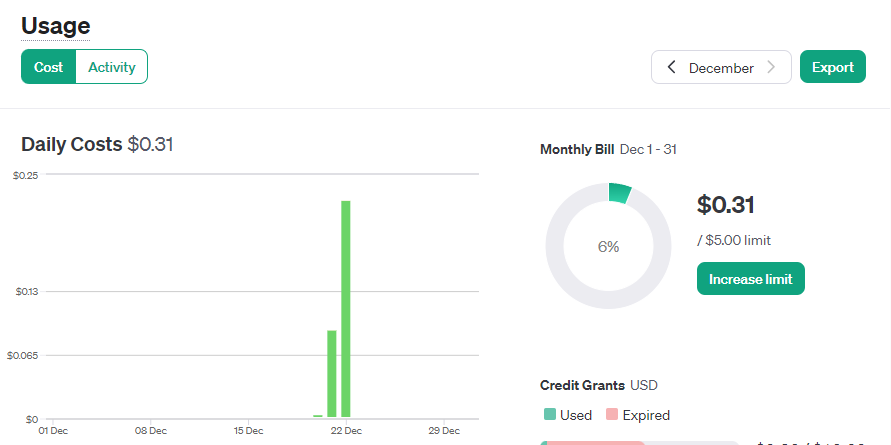